# Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо выполнить предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов:**

Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей.
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика.
3.	Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля,
- сообщение: 3 рубля,
- 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»
1.	Ежемесячная плата: 1950 рублей.
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика.
3.	Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль,
- сообщение: 1 рубль,
- 1 Гб интернет-трафика: 150 рублей.

Важно: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

**Описание данных**

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя,
- first_name — имя пользователя,
- last_name — фамилия пользователя,
- age — возраст пользователя (годы),
- reg_date — дата подключения тарифа (день, месяц, год),
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных),
- city — город проживания пользователя,
- tariff — название тарифного плана.

Таблица calls (информация о звонках):
- id — уникальный номер звонка,
- call_date — дата звонка,
- duration — длительность звонка в минутах,
- user_id — идентификатор пользователя, сделавшего звонок.

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения,
- message_date — дата сообщения,
- user_id — идентификатор пользователя, отправившего сообщение.

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии,
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах),
- session_date — дата интернет-сессии,
- user_id — идентификатор пользователя.

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа,
- rub_monthly_fee — ежемесячная абонентская плата в рублях,
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату,
- messages_included — количество сообщений в месяц, включённых в абонентскую плату,
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах),
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата),
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета,
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).


## Шаг 1. Знакомство с данными

Добавляем все необходимые библиотеки.

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

Импортируем файлы.

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

Более детально просматриваем каждую из таблиц.

**Таблица calls**

In [3]:
calls.info()
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


В таблице calls содержится следующая информация: уникальный идентификатор звонка, дата звонка, его продолжительность и id пользователя. Пропусков нет. Тип данных для всех столбцов, кроме call_date, указан корректно. Столбец call_date необходимо привести к типу DateTime.

In [4]:
calls['user_id'].describe()

count    202607.000000
mean       1253.940619
std         144.722751
min        1000.000000
25%        1126.000000
50%        1260.000000
75%        1379.000000
max        1499.000000
Name: user_id, dtype: float64

Убедимся в том, что id пользователей совпадают с заявленными и являются одинаковыми во всех таблицах (от 1000 до 1499, всего 500 пользователей).

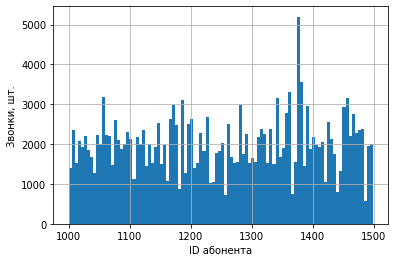

In [5]:
graph_1 = calls['user_id'].hist(bins=100)
graph_1.set_xlabel('ID абонента')
graph_1.set_ylabel('Звонки, шт.')
plt.show()

Видим, что количество звонков не растет и не уменьшается с ростом порядкового номера клиента (распределено однородно). Это говорит о случайном характере выбора абонентов из общего пула клиентов.

In [6]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Продолжительность каждого из звонков составляет от 0 до 38 минут. Построим гистограмму, чтобы ознакомиться с распределением звонков по длительности более детально.

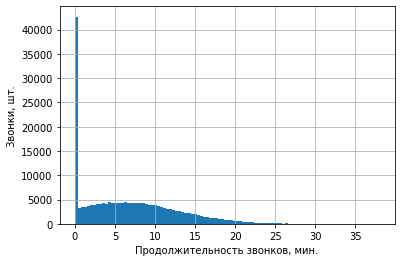

In [7]:
graph_2 = calls['duration'].hist(bins=100)
graph_2.set_xlabel('Продолжительность звонков, мин.')
graph_2.set_ylabel('Звонки, шт.')
plt.show()

Значительное число звонков обладает нулевой длительностью. Скорее всего, это звонки, во время которых звонивший не смог дозвониться до вызываемого абонента. Данные звонки не тарифицируются, а следовательно, не должны учитываться в последующих расчетах. Строки таблицы calls, в которых фигурируют звонки с нулевой длительностью, необходимо удалить.

**Таблица internet**

In [8]:
internet.info()
internet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Таблица internet содержит следующие данные: уникальный идентификатор сессии, объем использованного трафика, дата сессии, и id пользователя. Пропусков нет. Тип данных для всех столбцов, кроме session_date, указан корректно. Столбец session_date необходимо привести к типу DateTime.

In [9]:
internet['user_id'].describe()

count    149396.000000
mean       1252.099842
std         144.050823
min        1000.000000
25%        1130.000000
50%        1251.000000
75%        1380.000000
max        1499.000000
Name: user_id, dtype: float64

Убедимся в том, что id пользователей совпадают с заявленными и являются одинаковыми во всех таблицах (от 1000 до 1499, всего 500 пользователей).

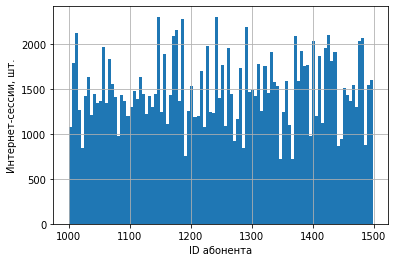

In [10]:
graph_3 = internet['user_id'].hist(bins=100)
graph_3.set_xlabel('ID абонента')
graph_3.set_ylabel('Интернет-сессии, шт.')
plt.show()

Также, как и в таблице calls, количество интернет-сессий не зависит от возрастания/убывания id пользователя.

In [11]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Взглянем на информацию об использованном интернет-трафике более детально. За одну сессию пользователи тратили от 0 до 1725 мегабайт. Очевидно, что сессии с нулевым трафиком — такая же проблема, как и звонки с нулевой продолжительностью. Оплата производится за использованные мегабайты, а значит, все наблюдения в таблице internet,  в которых объем трафика равен нулю, необходимо удалить. 

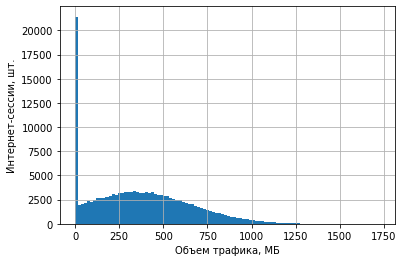

In [12]:
graph_4 = internet['mb_used'].hist(bins=100)
graph_4.set_xlabel('Объем трафика, МБ')
graph_4.set_ylabel('Интернет-сессии, шт.')
plt.show()

Построим гистограмму и убедимся в том, что подобных наблюдений достаточно много. Оставшись в таблице, они могут негативно отразиться на точности проводимого исследования.

**Таблица messages**

In [13]:
messages.info()
messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Таблица messages содержит следующие данные: уникальный идентификатор сообщения, дата сообщения, и id пользователя. Пропусков нет. Тип данных для всех столбцов, кроме message_date, указан корректно. Столбец session_date необходимо привести к типу DateTime.

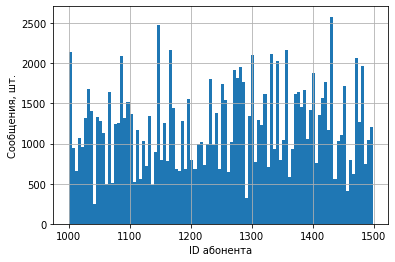

In [14]:
graph_5 = messages['user_id'].hist(bins=100)
graph_5.set_xlabel('ID абонента')
graph_5.set_ylabel('Сообщения, шт.')
plt.show()

Построим гистограмму, чтобы убедиться, что количество отправленных сообщений не зависит от возрастания/убывания id пользователя.

**Таблица tariffs**

In [15]:
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs содержит базовую информацию о тарифах. В ней всего две строки, по одной на каждый тариф: smart и ultra. В таблице указано количество бесплатных сообщений, мегабайт трафика и количества звонков, ежемесячно предоставляемых пользователям в рамках выбранного тарифного плана, а также размер абонентской платы, стоимость одного гигабайта интернет-трафика, одного сообщения и одной минуты разговора сверх предоставляемых в тарифе.

**Таблица users**

In [16]:
users.info()
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Таблица users — список всех пользователей, данные которых необходимо исследовать. В таблице указаны уникальный id каждого пользователя, его возраст, дата отключения (если имеется), город, имя и фамилия, а также дата подключения и выбранный тариф. Наблюдений ровно 500 (расхождений с другими таблицами не наблюдается). Тип данных для всех столбцов, кроме churn_date и reg_date, указан корректно.

In [17]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Возраст клиентов варьируется в диапазоне от 18 до 75 лет. Построим гистограмму. Параметр bins равен разнице между максимальным и минимальным возрастом в таблице. Таким образом для каждого года получаем ровно один столбец. Судя по гистограмме, возраст клиентов тоже случаен, все возрастные группы представлены в равной степени.

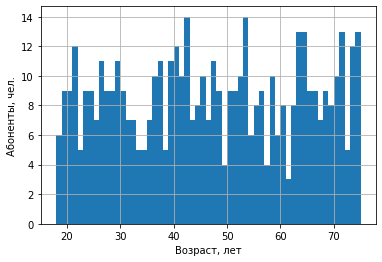

In [18]:
graph_6 = users['age'].hist(bins=57)
graph_6.set_xlabel('Возраст, лет')
graph_6.set_ylabel('Абоненты, чел.')
plt.show()

Проверяем наличие ошибок в названии тарифов. Видим, что в сумме получается 500, а значений всего два. Следовательно, ошибок нет.

In [19]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

### Вывод

Для работы у нас имеется 5 таблиц. Две из них — с общими данными о тарифах и клиентах. Три оставшиеся — с информацией по звонкам, сообщениям и интернет-трафику. После первичного ознакомления можно сказать, что в целом данные выглядят корректно, за исключением звонков с нулевой длительностью и интернет-сессий с нулевым трафиком, а также неверно указанным типом данных для всех столбцов во всех таблицах, имеющим отношение к датам. Наблюдения с нулевыми звонками и нулевыми сессии необходимо удалить, тип данных в столбцах, содержащих даты, изменить на DateTime.

## Шаг 2. Подготовка данных

Приведем данные во всех  таблицах к нужному типу, исправим ошибки.

**Таблица calls**

In [20]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Переведем столбец call_date к типу данных DateTime. Удалим звонки с нулевой длительностью: плата за такие звонки не взимается, но их наличие может негативно сказаться на точности проводимого анализа. Проверим.

In [21]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls = calls.query('duration > 0')
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         162994 non-null  object        
 1   call_date  162994 non-null  datetime64[ns]
 2   duration   162994 non-null  float64       
 3   user_id    162994 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Убедимся в том, что все наблюдения зафиксированы на нужном временном отрезке (в условии указано, что вся имеющаяся информация была получена в 2018 году). Действительно, все наблюдения оказались в диапазоне между 2018-01-01 и 2018-12-31.

In [22]:
calls['call_date'].describe()

count                  162994
unique                    365
top       2018-12-31 00:00:00
freq                     1173
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

Проверяем на наличие грубых дубликатов. Убеждаемся в том, что их нет.

In [23]:
calls.duplicated().sum()

0

Выявим и удалим аномальные значения в столбце duration. Для этого рассчитаем межквартильный размах и удалим все значения, меньшие чем разница первой квартили и 1,5 межквартильных размаха или большие чем сумма третьей квартили и 1,5 межквартильных размахов. Построим график типа "ящик с усами" до и после удаления выбросов, чтобы визуально убедиться в том, как изменилась выборка.

Text(0, 0.5, 'Продолжительность звонка, мин.')

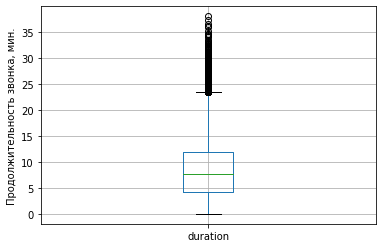

In [24]:
calls.boxplot(column='duration').set_ylabel('Продолжительность звонка, мин.')

Text(0, 0.5, 'Продолжительность звонка, мин.')

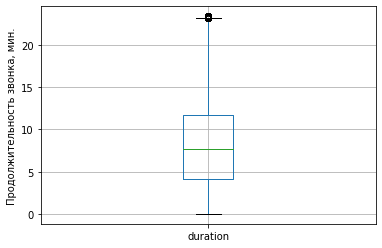

In [25]:
Q1_calls = calls['duration'].quantile(0.25)
Q3_calls = calls['duration'].quantile(0.75)
IQR_calls = Q3_calls - Q1_calls
calls = calls.query('(@Q1_calls - 1.5 * @IQR_calls) <= duration <= (@Q3_calls + 1.5 * @IQR_calls)')
calls.boxplot(column='duration').set_ylabel('Продолжительность звонка, мин.')

Мобильный оператор округляет длительность всех звонков до целых минут в большую сторону, но на данный момент в таблице указана фактическая, а не расчетная длительность разговоров. Округляем минуты, переводим данные в целочисленный тип.

In [26]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype('int')
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161690 entries, 2 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         161690 non-null  object        
 1   call_date  161690 non-null  datetime64[ns]
 2   duration   161690 non-null  int32         
 3   user_id    161690 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.6+ MB


**Таблица internet**

In [27]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Переведем столбец session_date к типу данных DateTime. Удалим сессии с нулевым трафиком.

In [28]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet = internet.query('mb_used > 0')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    129798 non-null  int64         
 1   id            129798 non-null  object        
 2   mb_used       129798 non-null  float64       
 3   session_date  129798 non-null  datetime64[ns]
 4   user_id       129798 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.9+ MB


Также, как и в случае с предыдущей таблицей, проверяем диапазон дат, в которые совершались наблюдения.

In [29]:
internet['session_date'].describe()

count                  129798
unique                    365
top       2018-12-31 00:00:00
freq                      916
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

Проверяем таблицу на наличие грубых дубликатов. Их нет.

In [30]:
internet.duplicated().sum()

0

Определим и удалим аномальные значения в столбце mb_used. Для этого рассчитаем межквартильный размах и удалим все значения, меньшие чем разница первой квартили и 1,5 межквартильных размаха или большие чем сумма третьей квартили и 1,5 межквартильных размахов. Так же, как и в случае с предыдущей таблицей, построим график типа "ящик с усами" до и после удаления выбросов.

Text(0, 0.5, 'Интернет-трафик, МБ')

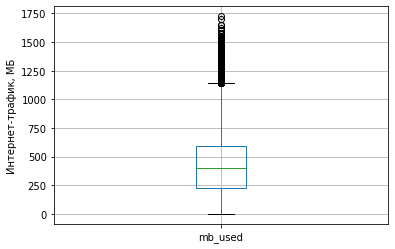

In [31]:
internet.boxplot(column='mb_used').set_ylabel('Интернет-трафик, МБ')

Text(0, 0.5, 'Интернет-трафик, МБ')

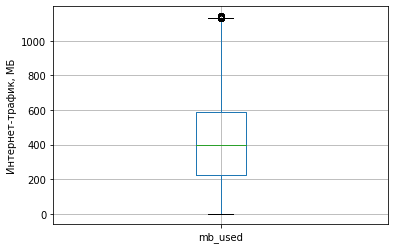

In [32]:
Q1_internet = internet['mb_used'].quantile(0.25)
Q3_internet = internet['mb_used'].quantile(0.75)
IQR_internet = Q3_internet - Q1_internet
internet = internet.query('(@Q1_internet - 1.5 * @IQR_internet) <= mb_used <= (@Q3_internet + 1.5 * @IQR_internet)')
internet.boxplot(column='mb_used').set_ylabel('Интернет-трафик, МБ')

Мобильный оператор округляет объем трафика для всех интернет-сессий до целых мегабайт в большую сторону, но на данный момент в таблице указан фактический, а не расчетный объем трафика. Округляем мегабайты, переводим данные в целочисленный тип. Проверяем.

In [33]:
internet['mb_used'] = np.ceil(internet['mb_used'])
internet['mb_used'] = internet['mb_used'].astype('int')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128941 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    128941 non-null  int64         
 1   id            128941 non-null  object        
 2   mb_used       128941 non-null  int32         
 3   session_date  128941 non-null  datetime64[ns]
 4   user_id       128941 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 5.4+ MB


**Таблица messages**

In [34]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Как и в двух предыдущих таблицах, заменим тип данных в столбце, отвечающем за дату отправки сообщения, на DateTime.

In [35]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Удостоверимся в том, что все даты оказались в искомом временном промежутке.

In [36]:
messages['message_date'].describe()

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

Проверим таблицу на наличие грубых дубликатов. Их нет.

In [37]:
messages.duplicated().sum()

0

**Таблица tariffs**

In [38]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Все в порядке, никакие манипуляции не требуются.

**Таблица users**

In [39]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Видим, что в столбце churn_date много пропусков (из 500 строк заполнены только 38), но это нормально, ведь для абонентов, которые до сих пор пользуются услугами мобильного оператора, он и должен оставаться незаполненным. Изменим формат данных на DateTime для столбцов churn_date и reg_date.

In [40]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart


In [41]:
users['reg_date'].describe()

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

Убедимся в том, что в таблице нет грубых дубликатов.

In [42]:
users.duplicated().sum()

0

### Расчеты

Для каждого пользователя рассчитаем:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- ежемесячную выручку.


Начнем с количества звонков и израсходованных минут по месяцам. Создаем отдельный столбец с месяцами.

In [43]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.head()

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9


Группируем данные по пользователям и месяцам с помощью сводной таблицы, вычисляем количество звонков и их продолжительность для каждого пользователя за каждый месяц.

In [44]:
calls_pivot = calls.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc = ('count', 'sum'))
calls_pivot.columns = ['calls', 'total_duration']
calls_pivot

calls  total_duration
user_id month                       
1000    5         17             159
        6         28             172
        7         41             340
        8         41             384
        9         46             466
...              ...             ...
1498    10        30             247
1499    9          7              45
        10        44             449
        11        61             587
        12        56             492

[3168 rows x 2 columns]

Построим гистограммы. Убедимся в том, что между количеством звонков и их суммарной длительностью есть определенная зависимость, что логично: в среднем, чем больше звонков делает человек, тем больше времени он проведет разговаривая по телефону.

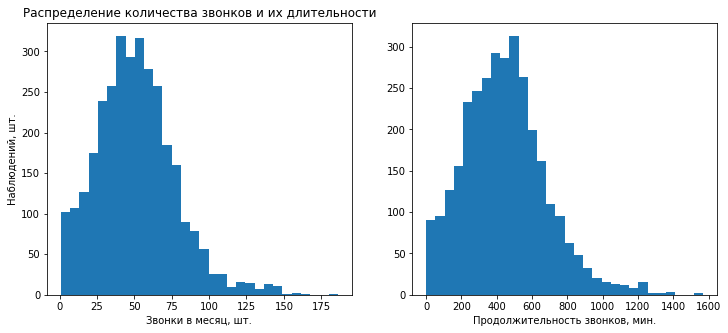

In [45]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(calls_pivot['calls'], bins=30)
plt.title('Распределение количества звонков и их длительности')
plt.xlabel('Звонки в месяц, шт.')
plt.ylabel('Наблюдений, шт.')

plt.subplot(1, 2, 2)
plt.hist(calls_pivot['total_duration'], bins=30)
plt.xlabel('Продолжительность звонков, мин.')

plt.show()

Количество отправленных сообщений по месяцам. Создаем отдельный столбец с месяцами.

In [46]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Группируем данные по пользователям и месяцам с помощью сводной таблицы, вычисляем количество сообщений для каждого пользователя за каждый месяц.

In [47]:
messages_pivot = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count')
messages_pivot.columns = ['messages']
messages_pivot

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

С помощью гистограммы оценим тип распределения данных для количества отправленных сообщений. Можно утверждать, что большинство людей отправляют не больше 150 сообщений в месяц, хотя для некоторых это значение превышает 200.

<function matplotlib.pyplot.show(*args, **kw)>

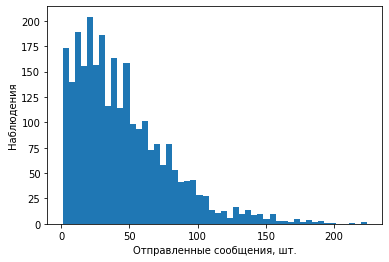

In [48]:
plt.hist(messages_pivot['messages'], bins=50)
plt.xlabel('Отправленные сообщения, шт.')
plt.ylabel('Наблюдения')
plt.show

Объем израсходованного интернет-трафика по месяцам.

In [49]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,113,2018-11-25,1000,11
1,1,1000_1,1053,2018-09-07,1000,9
3,3,1000_3,551,2018-08-22,1000,8
4,4,1000_4,303,2018-09-24,1000,9
5,5,1000_5,400,2018-10-02,1000,10


Группируем данные по пользователям и месяцам с помощью сводной таблицы, вычисляем общий объем интернет-трафика для каждого пользователя за каждый месяц.

In [50]:
internet_pivot = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum')
internet_pivot

mb_used
user_id month         
1000    5         2256
        6        22059
        7        14016
        8        14070
        9        14581
...                ...
1498    10       20604
1499    9         1848
        10       16624
        11       15449
        12       13077

[3201 rows x 1 columns]

С помощью гистограммы убеждаемся в том, что тип распределения в данном случае приближен к нормальному.

<function matplotlib.pyplot.show(*args, **kw)>

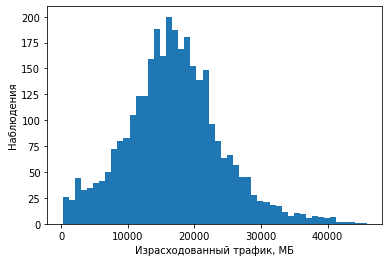

In [51]:
plt.hist(internet_pivot['mb_used'], bins=50)
plt.xlabel('Израсходованный трафик, МБ')
plt.ylabel('Наблюдения')
plt.show

Создадим общую сводную таблицу, заполним пропуски.

In [52]:
all_data = pd.merge(calls_pivot, messages_pivot, how='outer', on = ["user_id", "month"] )
all_data = pd.merge(all_data, internet_pivot, how='outer', on = ["user_id", "month"] )
all_data = all_data.sort_values(by=['user_id', 'month'])
all_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1499, 12)
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   calls           3168 non-null   float64
 1   total_duration  3168 non-null   float64
 2   messages        2717 non-null   float64
 3   mb_used         3201 non-null   float64
dtypes: float64(4)
memory usage: 114.0 KB


Данный тип создания обобщенной сводной таблицы поможет учесть любую активность в те месяцы, в которые абонент пользовался услугами мобильного оператора, будь то сообщения, звонки, интернет или все сразу. Пропуски заполним нулями, так как отсутствие данных в данном случае говорит о том, что в определенный месяц данный вид связи не использовался.

In [53]:
all_data.fillna(0, inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1499, 12)
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   calls           3214 non-null   float64
 1   total_duration  3214 non-null   float64
 2   messages        3214 non-null   float64
 3   mb_used         3214 non-null   float64
dtypes: float64(4)
memory usage: 114.0 KB


Получаем таблицу вида:

In [54]:
all_data

calls  total_duration  messages  mb_used
user_id month                                          
1000    5       17.0           159.0      22.0   2256.0
        6       28.0           172.0      60.0  22059.0
        7       41.0           340.0      75.0  14016.0
        8       41.0           384.0      81.0  14070.0
        9       46.0           466.0      57.0  14581.0
...              ...             ...       ...      ...
1498    10      30.0           247.0      42.0  20604.0
1499    9        7.0            45.0      11.0   1848.0
        10      44.0           449.0      48.0  16624.0
        11      61.0           587.0      59.0  15449.0
        12      56.0           492.0      66.0  13077.0

[3214 rows x 4 columns]

Создадим списки абонентов тарифов "Ультра" и "Смарт".

In [55]:
ultra_users = users.query('tariff == "ultra"')
ultra_users_id = ultra_users['user_id'].tolist()
smart_users = users.query('tariff == "smart"')
smart_users_id = smart_users['user_id'].tolist()

Трансформируем сводную таблицу в обычную таблицу для удобства проведения расчетов.

In [56]:
flat_data = pd.DataFrame(all_data.to_records())
flat_data

,user_id,month,calls,total_duration,messages,mb_used
0,1000,5,17.0,159.0,22.0,2256.0
1,1000,6,28.0,172.0,60.0,22059.0
2,1000,7,41.0,340.0,75.0,14016.0
3,1000,8,41.0,384.0,81.0,14070.0
4,1000,9,46.0,466.0,57.0,14581.0
...,...,...,...,...,...,...
3209,1498,10,30.0,247.0,42.0,20604.0
3210,1499,9,7.0,45.0,11.0,1848.0
3211,1499,10,44.0,449.0,48.0,16624.0
3212,1499,11,61.0,587.0,59.0,15449.0


Заполним столбец с тарифами, обратившись к ранее созданным спискам абонентов для каждого из тарифов.

In [57]:
flat_data.loc[flat_data['user_id'].isin(ultra_users_id), 'tariff'] = "ultra"
flat_data.loc[flat_data['user_id'].isin(smart_users_id), 'tariff'] = "smart"
flat_data['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

Рассчитаем количество минут для каждого абонента по месяцам, за которые будет взиматься плата. Так как количество включенных минут у тарифов разное, то и считать для каждого тарифа будем по-своему.

In [58]:
flat_data.loc[flat_data['tariff'] == "ultra", 'paid_calls'] = flat_data['total_duration'] - tariffs.loc[1, 'minutes_included']
flat_data.loc[flat_data['tariff'] == "smart", 'paid_calls'] = flat_data['total_duration'] - tariffs.loc[0, 'minutes_included']
flat_data.loc[flat_data['paid_calls'] < 0, 'paid_calls'] = 0
flat_data

,user_id,month,calls,total_duration,messages,mb_used,tariff,paid_calls
0,1000,5,17.0,159.0,22.0,2256.0,ultra,0.0
1,1000,6,28.0,172.0,60.0,22059.0,ultra,0.0
2,1000,7,41.0,340.0,75.0,14016.0,ultra,0.0
3,1000,8,41.0,384.0,81.0,14070.0,ultra,0.0
4,1000,9,46.0,466.0,57.0,14581.0,ultra,0.0
...,...,...,...,...,...,...,...,...
3209,1498,10,30.0,247.0,42.0,20604.0,smart,0.0
3210,1499,9,7.0,45.0,11.0,1848.0,smart,0.0
3211,1499,10,44.0,449.0,48.0,16624.0,smart,0.0
3212,1499,11,61.0,587.0,59.0,15449.0,smart,87.0


Визуально сравним количество минут сверх предоставляемого лимита для пользователей двух тарифов. Видим, что в случае тарифа "Смарт" большая часть пользователей использовала количество минут, меньшее или равное оговоренному в тарифе, но есть и определенный процент людей, превысивших лимит. Для последних стоимость дополнительных минут разговора будет рассчитываться отдельно. В то же время все пользователи тарифа "Ультра" не превысили свой ежемесячный лимит времени разговоров.

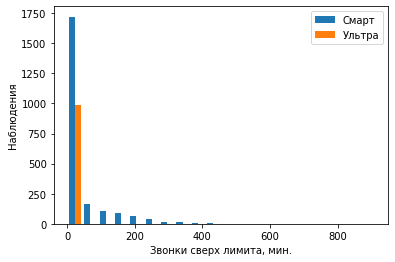

In [59]:
plt.hist([flat_data.query('tariff == "smart"')['paid_calls'], flat_data.query('tariff == "ultra"')['paid_calls']], bins=20, label=['Смарт', 'Ультра'])
plt.xlabel('Звонки сверх лимита, мин.')
plt.ylabel('Наблюдения')
plt.legend(loc='upper right')

plt.show()

Рассчитаем количество сообщений для каждого абонента по месяцам, за которые будет взиматься плата (аналогично минутам разговора).

In [60]:
flat_data.loc[flat_data['tariff'] == "ultra", 'paid_messages'] = flat_data['messages'] - tariffs.loc[1, 'messages_included']
flat_data.loc[flat_data['tariff'] == "smart", 'paid_messages'] = flat_data['messages'] - tariffs.loc[0, 'messages_included']
flat_data.loc[flat_data['paid_messages'] < 0, 'paid_messages'] = 0
flat_data

,user_id,month,calls,total_duration,messages,mb_used,tariff,paid_calls,paid_messages
0,1000,5,17.0,159.0,22.0,2256.0,ultra,0.0,0.0
1,1000,6,28.0,172.0,60.0,22059.0,ultra,0.0,0.0
2,1000,7,41.0,340.0,75.0,14016.0,ultra,0.0,0.0
3,1000,8,41.0,384.0,81.0,14070.0,ultra,0.0,0.0
4,1000,9,46.0,466.0,57.0,14581.0,ultra,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3209,1498,10,30.0,247.0,42.0,20604.0,smart,0.0,0.0
3210,1499,9,7.0,45.0,11.0,1848.0,smart,0.0,0.0
3211,1499,10,44.0,449.0,48.0,16624.0,smart,0.0,0.0
3212,1499,11,61.0,587.0,59.0,15449.0,smart,87.0,9.0


Визуально сравним количество минут сверх предоставляемого лимита для пользователей двух тарифов. Видим, что и здесь наблюдается аналогичная картина. Ни один из пользователей тарифа "Ультра" не превысил свой ежемесячный лимит, в то время как некоторые пользователи тарифа "Смарт" отправили куда больше сообщений, чем допускает их тарифный план.

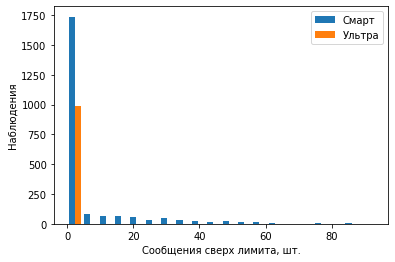

In [61]:
plt.hist([flat_data.query('tariff == "smart"')['paid_messages'], flat_data.query('tariff == "ultra"')['paid_messages']], bins=20, label=['Смарт', 'Ультра'])
plt.xlabel('Сообщения сверх лимита, шт.')
plt.ylabel('Наблюдения')
plt.legend(loc='upper right')

plt.show()

Рассчитаем объем трафика в мегабайтах для каждого абонента по месяцам, за который будет взиматься плата (аналогично сообщениям и звонкам).

In [62]:
flat_data.loc[flat_data['tariff'] == "ultra", 'paid_traffic'] = flat_data['mb_used'] - tariffs.loc[1, 'mb_per_month_included']
flat_data.loc[flat_data['tariff'] == "smart", 'paid_traffic'] = flat_data['mb_used'] - tariffs.loc[0, 'mb_per_month_included']
flat_data.loc[flat_data['paid_traffic'] < 0, 'paid_traffic'] = 0
flat_data

,user_id,month,calls,total_duration,messages,mb_used,tariff,paid_calls,paid_messages,paid_traffic
0,1000,5,17.0,159.0,22.0,2256.0,ultra,0.0,0.0,0.0
1,1000,6,28.0,172.0,60.0,22059.0,ultra,0.0,0.0,0.0
2,1000,7,41.0,340.0,75.0,14016.0,ultra,0.0,0.0,0.0
3,1000,8,41.0,384.0,81.0,14070.0,ultra,0.0,0.0,0.0
4,1000,9,46.0,466.0,57.0,14581.0,ultra,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,30.0,247.0,42.0,20604.0,smart,0.0,0.0,5244.0
3210,1499,9,7.0,45.0,11.0,1848.0,smart,0.0,0.0,0.0
3211,1499,10,44.0,449.0,48.0,16624.0,smart,0.0,0.0,1264.0
3212,1499,11,61.0,587.0,59.0,15449.0,smart,87.0,9.0,89.0


Сравним объем интернет-трафика сверх установленного лимита для абонентов обоих тарифов. Видим, что ситуация несколько отличается от той, которая наблюдалась в случае платных сообщений и минут разговора. Пользователи обоих тарифов используют большее количество трафика, чем установлено в их тарифном плане, но абоненты "Ультра" все же делают это реже, чем пользователи "Смарт" (видимо, дело в самом лимите, который в случае "Смарт" в два раза ниже).

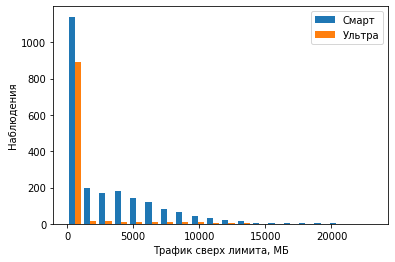

In [63]:
plt.hist([flat_data.query('tariff == "smart"')['paid_traffic'], flat_data.query('tariff == "ultra"')['paid_traffic']], bins=20, label=['Смарт', 'Ультра'])
plt.xlabel('Трафик сверх лимита, МБ')
plt.ylabel('Наблюдения')
plt.legend(loc='upper right')

plt.show()

Рассчитаем выручку: вычитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножаем на значение из тарифного плана; прибавляем абонентскую плату, соответствующую тарифному плану. Значение mb_used делим на 1000, т. к. цены в тарифном плане указана за гигабайт.

In [64]:
flat_data.loc[flat_data['tariff'] == "ultra", 'revenue'] = (flat_data['paid_calls'] * tariffs.loc[1, 'rub_per_minute']
                                                            + flat_data['paid_messages'] * tariffs.loc[1, 'rub_per_message']
                                                            + flat_data['paid_traffic'] * tariffs.loc[1, 'rub_per_gb'] / 1000
                                                            + tariffs.loc[1, 'rub_monthly_fee']
                                                           )
flat_data.loc[flat_data['tariff'] == "smart", 'revenue'] = (flat_data['paid_calls'] * tariffs.loc[0, 'rub_per_minute']
                                                            + flat_data['paid_messages'] * tariffs.loc[0, 'rub_per_message']
                                                            + flat_data['paid_traffic'] * tariffs.loc[0, 'rub_per_gb'] / 1000
                                                            + tariffs.loc[0, 'rub_monthly_fee']
                                                           )
flat_data.head(10)

,user_id,month,calls,total_duration,messages,mb_used,tariff,paid_calls,paid_messages,paid_traffic,revenue
0,1000,5,17.0,159.0,22.0,2256.0,ultra,0.0,0.0,0.0,1950.0
1,1000,6,28.0,172.0,60.0,22059.0,ultra,0.0,0.0,0.0,1950.0
2,1000,7,41.0,340.0,75.0,14016.0,ultra,0.0,0.0,0.0,1950.0
3,1000,8,41.0,384.0,81.0,14070.0,ultra,0.0,0.0,0.0,1950.0
4,1000,9,46.0,466.0,57.0,14581.0,ultra,0.0,0.0,0.0,1950.0
5,1000,10,44.0,350.0,73.0,14717.0,ultra,0.0,0.0,0.0,1950.0
6,1000,11,36.0,313.0,58.0,12153.0,ultra,0.0,0.0,0.0,1950.0
7,1000,12,37.0,309.0,70.0,9827.0,ultra,0.0,0.0,0.0,1950.0
8,1001,11,45.0,430.0,0.0,18452.0,smart,0.0,0.0,3092.0,1168.4
9,1001,12,47.0,414.0,0.0,14053.0,smart,0.0,0.0,0.0,550.0


Визуализируем выручку по месяцам для каждого абонента в зависимости от тарифа. Как и ожидалось, минимальное значение выручки на одного пользователя в месяц находится на уровне 550 рублей для тарифа "Смарт" и 1950 рублей для тарифа "Ультра". Минимальные значения для обоих тарифов равны соответствующей абонентской плате.

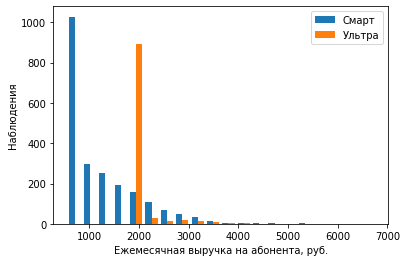

In [65]:
plt.hist([flat_data.query('tariff == "smart"')['revenue'], flat_data.query('tariff == "ultra"')['revenue']], bins=20, label=['Смарт', 'Ультра'])
plt.xlabel('Ежемесячная выручка на абонента, руб.')
plt.ylabel('Наблюдения')
plt.legend(loc='upper right')

plt.show()

Создадим два отдельных списка для пользователей из Москвы и из других регионов. Проверим.

In [66]:
moscow_users = users.query('city == "Москва"')
moscow_users_id = moscow_users['user_id'].tolist()

In [67]:
flat_data.loc[flat_data['user_id'].isin(moscow_users_id), 'city'] = "Москва"
flat_data.loc[~flat_data['user_id'].isin(moscow_users_id), 'city'] = "другой"
cities_df = flat_data['city'].value_counts()
cities_df

другой    2603
Москва     611
Name: city, dtype: int64

Визуально распределение абонентов по регионам выглядит следующим образом:

([<matplotlib.patches.Wedge at 0x144d9c8b688>,
 [Text(-0.9095830813842348, 0.6185940656517491, 'Москва'),
  Text(0.9095830524257557, -0.6185941082324057, 'прочие')],
 [Text(-0.4961362262095826, 0.33741494490095403, '81.0%'),
  Text(0.49613621041404843, -0.3374149681267667, '19.0%')])

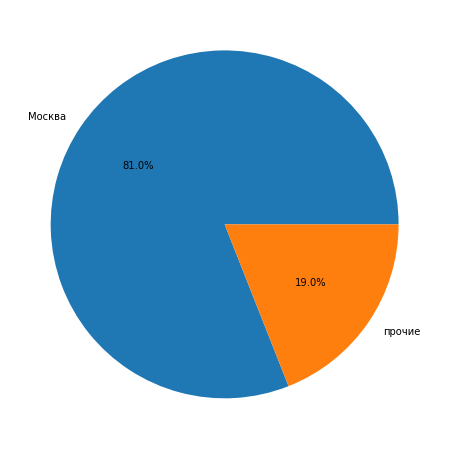

In [68]:
fracs = [2603/(2603+611), 611/(2603+611)]
plt.figure(figsize=(8, 8))
plt.pie(fracs, labels = ['Москва', 'прочие'], autopct='%1.1f%%')

In [69]:
flat_data

,user_id,month,calls,total_duration,messages,mb_used,tariff,paid_calls,paid_messages,paid_traffic,revenue,city
0,1000,5,17.0,159.0,22.0,2256.0,ultra,0.0,0.0,0.0,1950.0,другой
1,1000,6,28.0,172.0,60.0,22059.0,ultra,0.0,0.0,0.0,1950.0,другой
2,1000,7,41.0,340.0,75.0,14016.0,ultra,0.0,0.0,0.0,1950.0,другой
3,1000,8,41.0,384.0,81.0,14070.0,ultra,0.0,0.0,0.0,1950.0,другой
4,1000,9,46.0,466.0,57.0,14581.0,ultra,0.0,0.0,0.0,1950.0,другой
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,30.0,247.0,42.0,20604.0,smart,0.0,0.0,5244.0,1598.8,другой
3210,1499,9,7.0,45.0,11.0,1848.0,smart,0.0,0.0,0.0,550.0,другой
3211,1499,10,44.0,449.0,48.0,16624.0,smart,0.0,0.0,1264.0,802.8,другой
3212,1499,11,61.0,587.0,59.0,15449.0,smart,87.0,9.0,89.0,855.8,другой


Построим схожую визуализацию для абонентов из Москвы и регионов. По ней сложно сказать что-то наверняка, кроме того, что пользователей из регионов куда больше, чем из столицы (2603 человек против 611). Пики и в том, и в другом случае приходятся на значения, равные абонентской плате для каждого из тарифов.

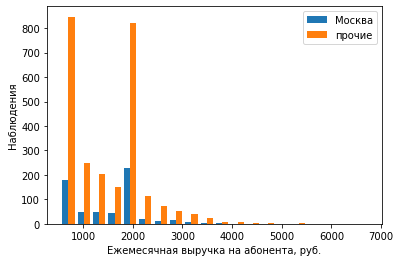

In [70]:
plt.hist([flat_data.query('city == "Москва"')['revenue'], flat_data.query('city == "другой"')['revenue']], bins=20, label=['Москва', 'прочие'])
plt.xlabel('Ежемесячная выручка на абонента, руб.')
plt.ylabel('Наблюдения')
plt.legend(loc='upper right')

plt.show()

### Вывод

На данном этапе мы привели все данные к необходимым типам, удалили ошибочные значения и выбросы, а также составили сводную таблицу, на основании которой можно будет рассчитать суммарную выручка от каждого клиента по месяцам, а также провести все прочие необходимые операции.

## Шаг 3. Анализ данных

Выясним, сколько минут разговора и сообщений, а также какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Для этого сначала посчитаем среднее для каждого пользователя. Так мы сможем получить более общую картину сначала для каждого абонента, а затем и для всех абонентов определенного тарифа. В противном случае разное количество месяцев, которое абонент пользовался услугами оператора, может исказить картину.

In [71]:
flat_pivot = flat_data.pivot_table(index=('tariff', 'user_id'), values=('total_duration', 'messages', 'mb_used', 'revenue'), aggfunc='mean')
flat_pivot.sort_values(by=['tariff', 'user_id'])

mb_used  messages      revenue  total_duration
tariff user_id                                                     
smart  1001     16252.500000       0.0   859.200000      422.000000
       1002     16597.571429      10.0   967.342857      212.857143
       1005      8317.750000      46.0   782.750000      535.666667
       1006     14625.545455       0.0   838.654545      311.363636
       1007     14643.555556      25.0   835.688889      469.000000
...                      ...       ...          ...             ...
ultra  1476     16311.888889       5.0  1950.000000      440.000000
       1485     23447.000000     155.0  1950.000000      560.000000
       1491     17547.000000      48.0  1950.000000      499.000000
       1493     25875.500000      47.0  2650.500000      359.500000
       1495     25507.200000      68.0  2269.110000      774.200000

[498 rows x 4 columns]

Построим гистограммы для использованного трафика, отправленных сообщений, выручки и продолжительности разговоров для абонентов тарифа "Смарт". Убедимся в том, что распределения использованного трафика и общей продолжительности разговоров приближены к нормальным. Распределение сообщений больше всего походит на гамма-распределение, а выручки — на экспоненциальное.

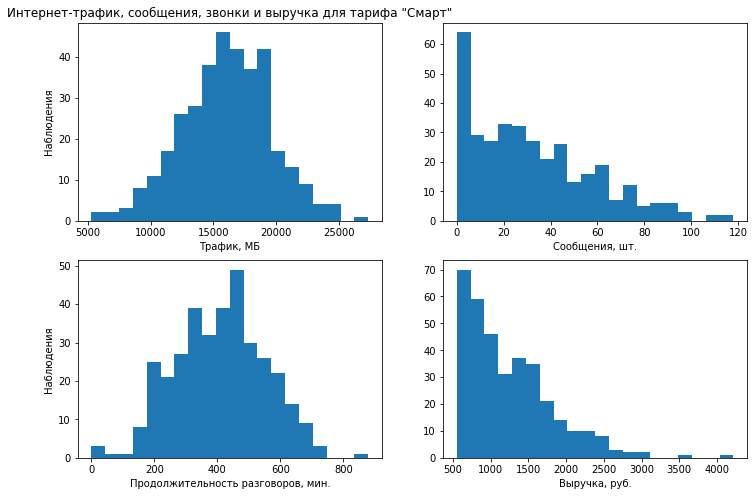

In [72]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(flat_pivot.query('tariff == "smart"')['mb_used'], bins=20)
plt.title('Интернет-трафик, сообщения, звонки и выручка для тарифа "Смарт"')
plt.xlabel('Трафик, МБ')
plt.ylabel('Наблюдения')
 
plt.subplot(2, 2, 2)
plt.hist(flat_pivot.query('tariff == "smart"')['messages'], bins=20)
plt.xlabel('Сообщения, шт.')

plt.subplot(2, 2, 3)
plt.hist(flat_pivot.query('tariff == "smart"')['total_duration'], bins=20)
plt.xlabel('Продолжительность разговоров, мин.')
plt.ylabel('Наблюдения')
 
plt.subplot(2, 2, 4)
plt.hist(flat_pivot.query('tariff == "smart"')['revenue'], bins=20)
plt.xlabel('Выручка, руб.')

plt.show()

Построим гистограммы для использованного трафика, отправленных сообщений, выручки и продолжительности разговоров для абонентов тарифа "Ультра". В данном случае невозможно утверждать, что распределения использованного трафика и общей продолжительности разговоров являются нормальными. Скорее можно просто утверждать, что оба параметра распределены унимодально. Количество сообщений и выручка распределены в соответствии с гамма-распределением.

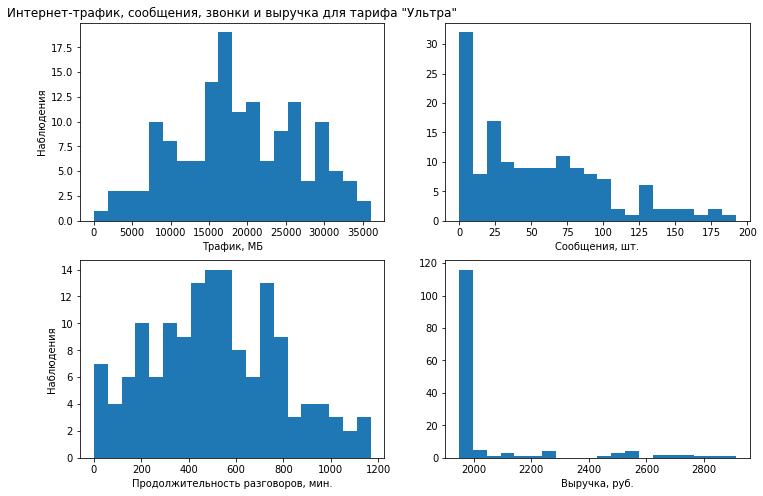

In [73]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(flat_pivot.query('tariff == "ultra"')['mb_used'], bins=20)
plt.title('Интернет-трафик, сообщения, звонки и выручка для тарифа "Ультра"')
plt.xlabel('Трафик, МБ')
plt.ylabel('Наблюдения')
 
plt.subplot(2, 2, 2)
plt.hist(flat_pivot.query('tariff == "ultra"')['messages'], bins=20)
plt.xlabel('Сообщения, шт.')

plt.subplot(2, 2, 3)
plt.hist(flat_pivot.query('tariff == "ultra"')['total_duration'], bins=20)
plt.xlabel('Продолжительность разговоров, мин.')
plt.ylabel('Наблюдения')
 
plt.subplot(2, 2, 4)
plt.hist(flat_pivot.query('tariff == "ultra"')['revenue'], bins=20)
plt.xlabel('Выручка, руб.')

plt.show()

Теперь рассчитаем, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение.

In [74]:
new_pivot = flat_pivot.pivot_table(index=('tariff'), values=('total_duration', 'messages', 'mb_used', 'revenue'), aggfunc=(np.mean, np.var, np.std))
new_pivot.applymap("{0:.1f}".format)

mb_used                     messages               revenue         \
           mean     std         var     mean   std     var    mean    std   
tariff                                                                      
smart   16055.1  3541.4  12541477.9     32.4  26.5   702.9  1243.3  580.8   
ultra   18824.8  7967.6  63482086.5     54.0  46.4  2149.8  2048.9  227.7   

                 total_duration                  
             var           mean    std      var  
tariff                                           
smart   337332.1          410.1  142.1  20179.1  
ultra    51827.2          514.9  275.8  76075.7

Пользователи тарифа "Смарт" в среднем используют 16055 МБ интернет-трафика каждый месяц (при стандартном отклонении 3541), в то время как пользователи тарифа "Ультра" — 18826, но и разброс значений у последних выше (стандартное отклонение равно 7968).

Абоненты тарифа "Смарт" в среднем отправляют по 32 сообщения ежемесячно (стандартное отклонение — 27). Пользователи тарифа "Ультра" в среднем отправляют по 54 сообщения каждый месяц, разброс значений здесь также выше (стандартное отклонение равно 46).

Наконец, пользователи тарифа "Смарт" в среднем проводили 410 минут, разговаривая по телефону (стандартное отклонение — 142), а пользователи "Ультра" — 514 минут, но и разброс значений здесь выше (стандартное отклонение равно 276).

По всем трем параметрам можно сказать, что данные пользователей тарифа "Смарт" куда больше сгруппированы вокруг среднего значения, а разброс значений меньше, чем у пользователей тарифа "Ультра". В то же время у пользователей тарифа "Ультра" все средние значения также гораздо выше, чем у абонентов "Смарт".

### Вывод

По результатам исследования можно утверждать, что поведение абонентов двух тарифов существенно различается. Пользователи тарифа "Ультра" могут похвастаться более высокими средними значениями во всех четырех категориях: звонки, сообщения, трафик и выручка. Но и вариативность в их данных выше. В то же время все средние значения для абонентов тарифа "Смарт" ниже, но и разброс куда меньше, все значения более плотно сгруппированы вокруг соответствующего среднего.

## Шаг 4. Проверка гипотез

Выдвинем и проверим гипотезу о наличии/отсутствии разницы между средними значениями выручки для абонентов тарифов "Смарт" и "Ультра". Базовая гипотеза предполагает, что разницы нет. АЛьтернативная — то, что разница присутствует.

- H0: средняя выручка тарифа "Смарт" **НЕ** отличается от средней выручки тарифа "Ультра".
- H1: средняя выручка тарифа "Смарт" отличается от средней выручки тарифа "Ультра".

Пороговое значение alpha задаем на уровне 0,05.

In [75]:
results_tariff = st.ttest_ind(flat_data.loc[flat_data['tariff'] == "smart", 'revenue'], flat_data.loc[flat_data['tariff'] == "ultra", 'revenue'])
results_tariff.pvalue

2.4855355511341447e-196

Получившееся p-значение гораздо меньше 0,05 (оно составляет 2,49^-196). На самом деле, оно гораздо меньше и 0,01, другого популярного уровня значимости. Следовательно, можно отбросить нулевую гипотезу и подтвердить наличие статистически значимой разницы между средними значениями выручки для тарифов "Смарт" и "Ультра". Действительно, из таблицы выше видно, что средняя выручка для тарифа "Смарт" составляет 1243 рублей в месяц, для тарифа "Ультра" — 2049 р. в месяц.

Визуально разница тоже выглядит достаточно значительной.

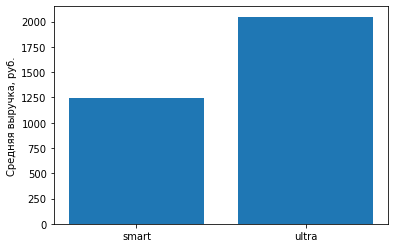

In [76]:
flat_tariff = pd.DataFrame(new_pivot.to_records())
flat_tariff.columns = ['tariff', 'mb_used_mean', 'mb_used_std', 'mb_used_var', 'messages_mean', 'messages_std', 'messages_var', 'revenue_mean', 'revenue_std', 'revenue_var', 'total_duration_mean', 'total_duration_std', 'total_duration_var']
plt.bar(flat_tariff['tariff'], flat_tariff['revenue_mean'])
plt.ylabel('Средняя выручка, руб.')
plt.show()

Теперь проверим гипотезу о наличии/отсутствии разницы между средними значениями выручки для абонентов из Москвы и регионов. Выдвигаем гипотезы аналогичным образом.

- H0: средняя выручка для абонентов из Москвы **НЕ** отличается от средней выручки для абонентов из регионов.
- H1: средняя выручка для абонентов из Москвы отличается от средней выручки для абонентов из регионов.

Пороговое значение alpha изначально также задаем на уровне 0,05.

In [77]:
results_city = st.ttest_ind(flat_data.loc[flat_data['city'] == "Москва", 'revenue'], flat_data.loc[flat_data['city'] == "другой", 'revenue'])
results_city.pvalue

0.4625701297214665

Взглянем на средние значения выручки для Москвы и регионов. Убедимся в том, что они действительно крайне близки.

In [78]:
city_pivot = flat_data.pivot_table(index='city', values='revenue', aggfunc='mean')
flat_city_pivot = pd.DataFrame(city_pivot.to_records())
flat_city_pivot

,city,revenue
0,Москва,1484.000164
1,другой,1458.570073


Визуально заметно, насколько незначительной является разница между средней выручкой для Москвы и регионов.

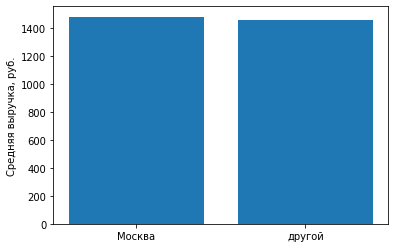

In [79]:
plt.bar(flat_city_pivot['city'], flat_city_pivot['revenue'])
plt.ylabel('Средняя выручка, руб.')
plt.show()

### Вывод

На основании имеющихся данных мы с 99% вероятностью можем утверждать, что между средней выручкой, которая приходится на одного клиента, абонентов тарифа "Смарт" и "Ультра" есть статистически значимая разница. В то же время, опровергнуть нулевую гипотезу, которая гласит, что средняя выручка для абонентов из Москвы **НЕ** отличается от средней выручки для абонентов из регионов, не удалось. Таким образом, мы не можем утверждать, что средняя выручка на абонента в месяц для москвичей и жителей регионов отличается.

## Шаг 5. Общий вывод

На первом этапе исследования мы изучили полученные данные (5 таблиц с разрозненной информацией о клиентах, тарифах, звонках, сообщения и интернет-сессиях), более детально изучили их на предмет наличия ошибок и некорректных значений, изменили тип данных на DateTime там, где это было необходимо, а также удалили наблюдения, относящиеся к звонкам с нулевой продолжительностью и интернет-сессиям с нулевым трафиком и исключили выбросы.

Использовав очищенные данные, мы рассчитали для каждого клиента:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- ежемесячную выручку.

На основании расчетных значений мы установили, как отличается поведение клиентов обоих тарифов: сколько СМС, минут разговора и мегабайт интернет-трафика в среднем требуется абонентам каждого из тарифов.

На заключительном этапе исследования мы выдвинули две пары гипотез. Одна из них — о разнице средней ежемесячной выручки для абонентов обоих тарифов. Другая — о разнице средней ежемесячной выручки для абонентов из Москвы и регионов. По результатам проверки гипотез можно утверждать, что средняя ежемесячная выручка для двух тарифов действительно различается, а вот статистически значимых различий между клиентами мобильного оператора из Москвы и регионов выявить не удалось.